# Imports

In [9]:
from config import config, colors
config = config.Configuration()
colors = colors.bcolors()

In [33]:
# True, if data should be inspected. Not necessary in pipeline
show_logs = True

# 1.1 Patch Generation

In [35]:
if show_logs: print("1.2 Patch Generation")
%run "patch_creation.py"

1.2 Patch Generation


<Figure size 432x288 with 0 Axes>

In [22]:
import numpy as np
patches_labels = np.load(config.path_patches_labels)
patches_satellite = np.load(config.path_patches_satellite)

# 1.2 Data Preparation for Training

In [27]:
patches_labels[418].shape, patches_satellite[418].shape

((256, 256), (256, 256, 3))

Single Patch:


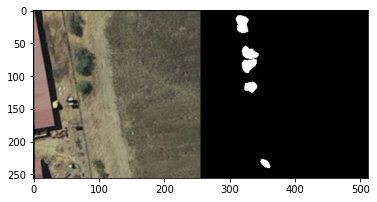

In [36]:
# visualize single patch
if show_logs: 
    from patch_creation import show
    print("Single Patch:")
    show(patches_satellite[0], patches_labels[0])

In [11]:
if show_logs: print("1.3 Data Preparation for Training")

## 1.3.1 Reshape Patches to Fit to the Model

In [12]:
if show_logs: print("Shape of One Label and Satellite Patch:", patches_labels[0].shape, patches_satellite[0].shape)

## 1.3.2 Feature Scaling & Data Correction

In [13]:
# scale the color values
patches_satellite_training = [patch/255 for patch in patches_satellite]

In [14]:
# Make all values of the array which are not 0, 1. Either label or no label. 
# This has to be performed, because the exported labels have color values, which have to be normalized. 
# Somehow, some color values have been above 255, which might have happened due to a faulty export from QGIS. 
# patches_labels_training = [patch==1.0 if patch != 0.0 else 0.0 for patch in patches_labels]
for patch in range(len(patches_labels)):
    for row in range(len(patches_labels[0])):
        patch_row = patches_labels[patch][row]
        patches_labels[patch][row] = np.where(patch_row != 0.0, 1.0, patch_row)

In [15]:
# for name consistency:
patches_labels_training = patches_labels

#### Create Training and Test Dataset

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patches_satellite_training, patches_labels_training, test_size=config.test_ratio, random_state=42)
X_train_mini, X_val, y_train_mini, y_val = train_test_split(X_train, y_train, test_size=config.val_ratio, random_state=42)

In [17]:
len(X_train)

830

Sanity Check of a Single Patch:


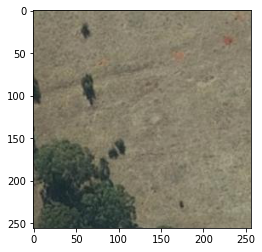

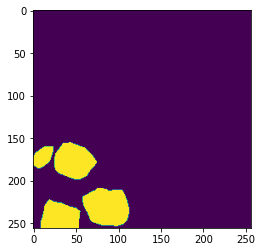

<AxesSubplot:>

In [261]:
# sanity check: check if satellite and label data matches
x = 810
print("Sanity Check of a Single Patch:")
show(X_train[x])
show(y_train[x])

#### Reshape Data for Data Augmentation and Model   

In [262]:
X_train = np.array(X_train)
prev_shape = X_train.shape
shape = X_train.shape
X_train = np.reshape(X_train, (shape[0], shape[2], shape[3], shape[1]))
if show_logs: print(f'Train: {prev_shape} => {X_train.shape}')


In [263]:
X_train_mini = np.array(X_train_mini)
prev_shape = X_train_mini.shape
shape = X_train_mini.shape
X_train_mini = np.reshape(X_train_mini, (shape[0], shape[2], shape[3], shape[1]))
if show_logs: print(f'Train: {prev_shape} => {X_train_mini.shape}')

In [264]:
# reshape data to fit model
X_test = np.array(X_test)
prev_shape = X_test.shape
shape = X_test.shape
X_test = np.reshape(X_test, (shape[0], shape[2], shape[3], shape[1]))
if show_logs: print(f'Test: {prev_shape} => {X_test.shape}')

In [265]:
# reshape data to fit model
X_val = np.array(X_val)
prev_shape = X_val.shape
shape = X_val.shape
X_val = np.reshape(X_val, (shape[0], shape[2], shape[3], shape[1]))
if show_logs: print(f'Validation: {prev_shape} => {X_val.shape}')

In [266]:
# convert y_train/test/val to numpy too
y_train = np.array(y_train)
y_train_mini = np.array(y_train_mini)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Data Augmentation

In [109]:
use_layer = True
use_datagen = not use_layer

In [25]:
def showImg(img, is_train: bool = True):
    if is_train:
        show(np.reshape(img, (3, 256, 256)))
    else: show(np.reshape(img, (1, 256, 256)))

## As a Layer

In [37]:
if use_layer:
  import tensorflow as tf
  from tensorflow.keras import layers
  data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(0.2),
  ])
  # Add the image to a batch.
  # image = tf.cast(tf.expand_dims(X_train, 0), tf.float32)
  # mask  = tf.cast(tf.expand_dims(y_train, 0), tf.float32)


In [73]:
X_train.shape, image.shape, y_train.shape, tf.cast(tf.expand_dims(y_train, 3), tf.float32).shape

((830, 256, 256, 3),
 TensorShape([256, 256, 3]),
 (830, 256, 256),
 TensorShape([830, 256, 256, 1]))

In [94]:
if use_layer:
    image = tf.cast(X_train, tf.float32)
    mask  = tf.cast(tf.expand_dims(y_train, 3), tf.float32)
    # ❗ thats all the same dataset
    train_ds = tf.data.Dataset.from_tensor_slices((image, mask))
    val_ds = tf.data.Dataset.from_tensor_slices((image, mask))
    test_ds = tf.data.Dataset.from_tensor_slices((image, mask))

In [95]:
if use_layer: print(image.shape, mask.shape)

(830, 256, 256, 3) (830, 256, 256, 1)


In [99]:
if use_layer:
  AUTOTUNE = tf.data.AUTOTUNE
  def prepare(ds, augment=False, shuffle=False):
    if shuffle:
      ds = ds.shuffle(1000)
    # Batch all datasets
    # ds = ds.batch(config.BATCH_SIZE)
    # Use data augmentation only on the training set.
    if augment:
      ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                  num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)


In [100]:
if use_layer:
    train_ds = prepare(train_ds, augment=True, shuffle=False)
    val_ds = prepare(val_ds)
    test_ds = prepare(test_ds)

In [102]:
len(patch), len(patch[10]), patch[10][0].shape, patch[10][1].shape

(830, 2, (256, 256, 3), (256, 256, 1))

In [108]:
type(patch[10][0])

numpy.ndarray

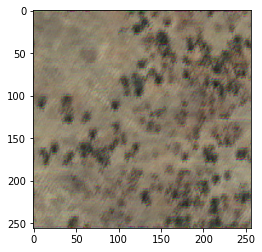

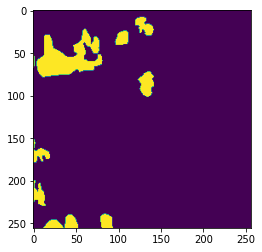

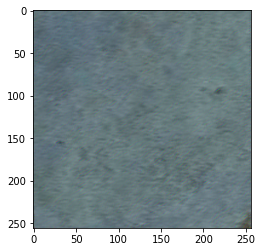

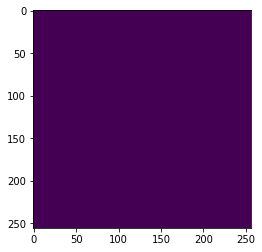

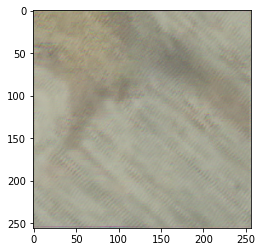

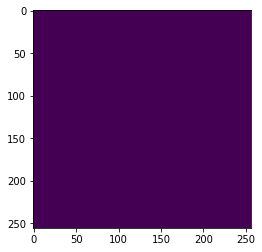

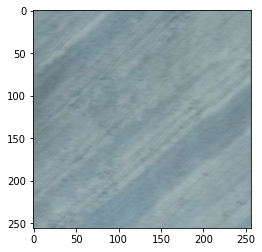

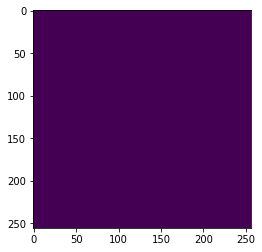

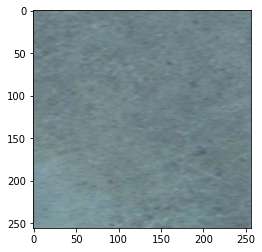

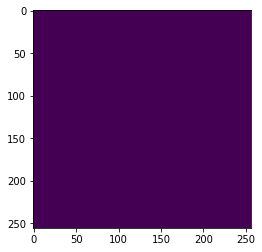

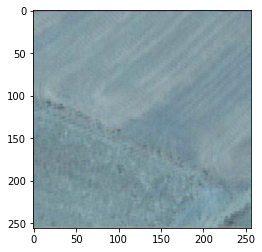

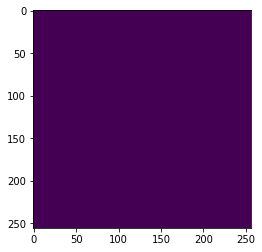

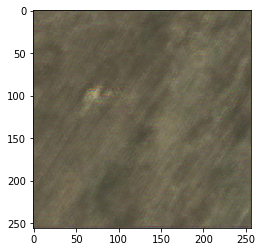

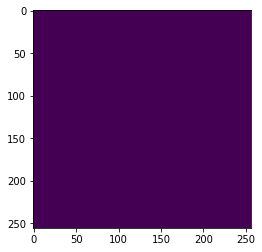

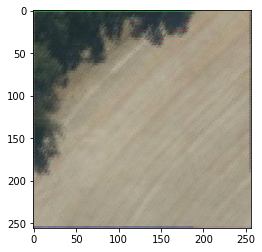

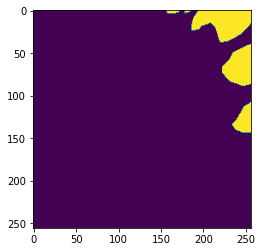

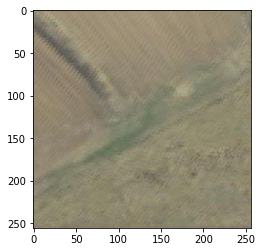

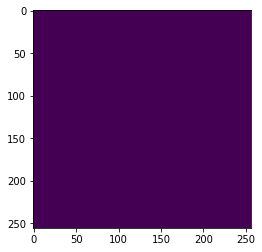

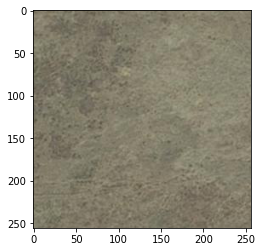

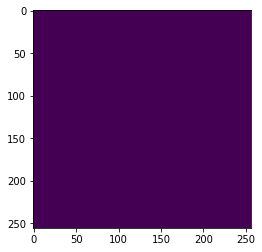

In [104]:
batch = 20
# max batch = 26
#max patch_num = 29
patch = list(train_ds.as_numpy_iterator())
for patch_num in range(10):
    showImg(patch[patch_num][0])
    show(patch[patch_num][1])

In [85]:
# if use_layer:
#   import matplotlib.pyplot as plt
#   plt.figure(figsize=(10, 10))
#   for i in range(9):
#     # print(image.shape)
#     augmented_image = data_augmentation(
#       (np.reshape(image, (3, 256, 256)),mask)
#       )
#     ax = plt.subplot(3, 3, i + 1)
#     # print(len(augmented_image), augmented_image[0].shape)
#     plt.imshow(augmented_image[0])
#     plt.axis("off")


In [242]:
X_train.shape

(830, 256, 256, 3)

In [166]:
# if use_layer: aug_ds = train_ds.map(lambda x, y: (resize_and_rescale(x, training=True), y))

## ImageDataGenerator

In [133]:
# showImg(X_train[12])
# showImg(y_train[12], False)

In [110]:
import matplotlib.pyplot as plt
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


In [27]:
x=12
image = X_train[x]
mask = y_train[x]

In [194]:
original = tf.image.flip_left_right(flipped)

In [137]:
mask.shape, flip_vertical_msk.shape

(TensorShape([830, 256, 256, 1]), TensorShape([256, 256, 1, 1]))

In [136]:
# row = 0
# print(flip_vertical_msk[0][0][row])
# print(mask[255][row])

In [135]:
# show(mask)
# show(flip_vertical_msk[0])

In [ ]:
showImg(image)
showImg(flip_vertical_img)

In [ ]:
##### !!! values are identical. only visualization is weird. Maybe because of data type. just train and see - recheck that statement

In [50]:
# from keras.preprocessing.image import ImageDataGenerator

# data_gen_args = dict(horizontal_flip=True
#                     #  featurewise_center=True,
#                     #  featurewise_std_normalization=True,
#                     #  rotation_range=90,
#                     #  width_shift_range=0.1,
#                     #  height_shift_range=0.1,
#                     #  zoom_range=0.2
#                      )
# img_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# seed = 1
# mask_datagen.fit(y_train_mini, augment=True, seed=seed)
# img_datagen.fit(X_train_mini, augment=True, seed=seed)

In [111]:
if use_datagen:
    from keras.preprocessing.image import img_to_array
    from numpy import expand_dims
    x_data = img_to_array(X_train[100])
    y_data = img_to_array(y_train[100])
    x_data_expanded = expand_dims(x_data, 0)
    y_data_expanded = expand_dims(y_data, 0)

In [131]:
if use_datagen:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
                                # rotation_range=135, #degree range for random rotation
                                data_format="channels_last", # (samples, height, width, channels)
                                horizontal_flip=True,
                                vertical_flip=True
                                # validation_split=config.val_ratio
                                #  featurewise_center=True,
                                #  featurewise_std_normalization=True,
                                #  width_shift_range=0.1,
                                #  height_shift_range=0.1,
                                #  zoom_range=0.2
                                )
    # datagen.fit(X_train)
    # y_train = np.reshape(y_train,(*y_train.shape,1))
    # datagen.fit(y_train)

In [121]:
image.shape, mask.shape, type(image)

(TensorShape([830, 256, 256, 3]),
 TensorShape([830, 256, 256, 1]),
 tensorflow.python.framework.ops.EagerTensor)

In [155]:
expand_dims(image[x], 0).shape, expand_dims(mask[x], 0).shape

((1, 256, 256, 3), (1, 256, 256, 1), TensorShape([1, 256, 256, 1]))

In [240]:
np.save("trainingdata_images.npy",image)
np.save("trainingdata_labels.npy",mask)

In [167]:
expand_dims(image[x], 0).shape

(1, 256, 256, 3)

(1, 256, 256, 3) (1, 256, 256, 1)


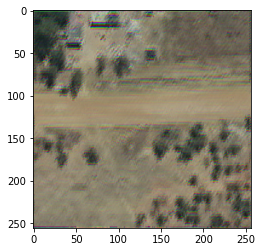

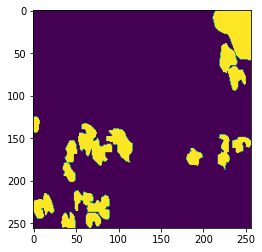

(1, 256, 256, 3) (1, 256, 256, 1)


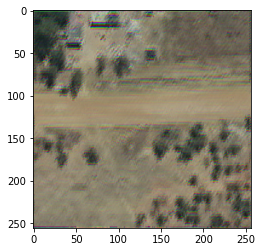

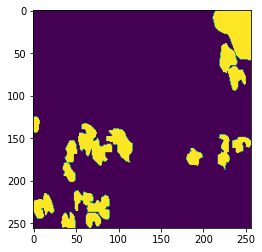

(1, 256, 256, 3) (1, 256, 256, 1)


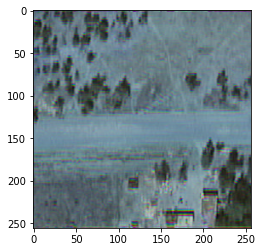

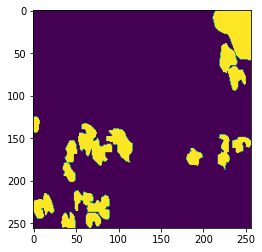

(1, 256, 256, 3) (1, 256, 256, 1)


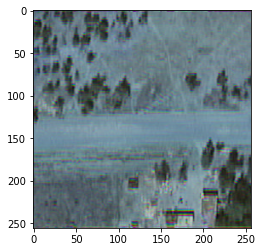

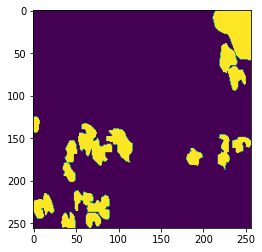

(1, 256, 256, 3) (1, 256, 256, 1)


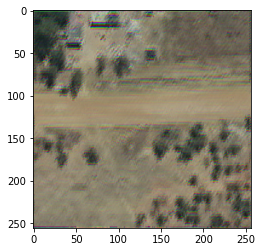

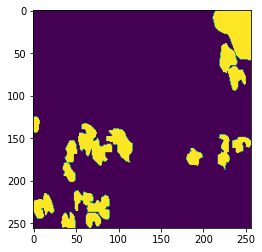

(1, 256, 256, 3) (1, 256, 256, 1)


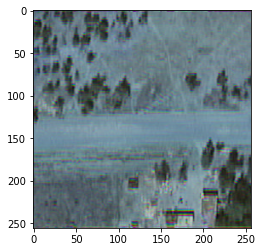

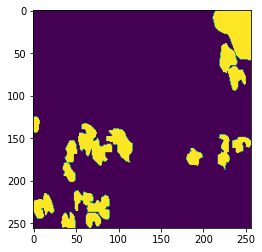

(1, 256, 256, 3) (1, 256, 256, 1)


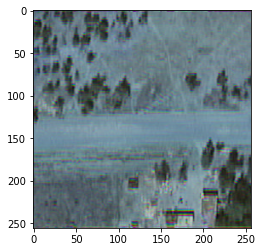

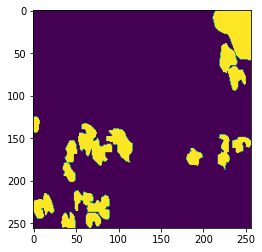

(1, 256, 256, 3) (1, 256, 256, 1)


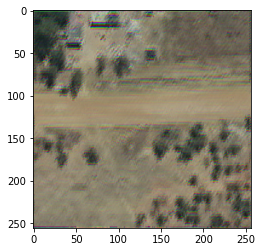

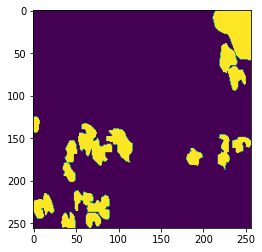

(1, 256, 256, 3) (1, 256, 256, 1)


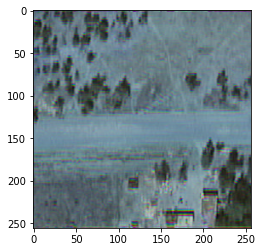

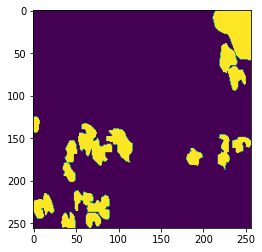

In [235]:
# ❗ only augments the first parameter
if use_datagen:
	x = 100
	single_image = expand_dims(image[x], 0)
	single_mask = expand_dims(mask[x], 0)
	it = datagen.flow(x=single_image, y=single_mask, batch_size=1)
	# As ndarray:
	# expand_dims(image[x], 0), expand_dims(mask[x], 0)
	# As EagerTensor:
	# tf.cast(expand_dims(image[x], 0), tf.float32), 
	# tf.cast(expand_dims(mask[x], 0), tf.float32)
	
	# generate samples and plot
	for i in range(9):
		# define subplot
		# pyplot.subplot(330 + 1 + i)
		# generate batch of images
		batch = it.next()
		print(batch[0].shape, batch[1].shape)
		# convert to unsigned integers for viewing
		# image = batch[0].astype('uint8')
		# plot raw pixel data
		# pyplot.imshow(image)
		# print(batch[0][0].shape, batch[1][0].shape)
		showImg(batch[0][0], True)
		# show(np.reshape(batch[0][0], (3, 256, 256)))
		show(batch[1][0])
		#  showImg(data_flow[x][0][patch_num], True)
		# showImg(data_flow[x][1][patch_num], False)
	# show the figure
	# pyplot.show()

In [ ]:
# does not work (!)
if use_datagen:
	it = datagen.flow(x_data_expanded, y_data_expanded, batch_size=1)
	# generate samples and plot
	for i in range(9):
		# define subplot
		# pyplot.subplot(330 + 1 + i)
		# generate batch of images
		batch = it.next()
		# convert to unsigned integers for viewing
		# image = batch[0].astype('uint8')
		# plot raw pixel data
		# pyplot.imshow(image)
		# print(batch[0][0].shape, batch[1][0].shape)
		showImg(batch[0][0], True)
		# show(np.reshape(batch[0][0], (3, 256, 256)))
		show(batch[1], False)
		#  showImg(data_flow[x][0][patch_num], True)
		# showImg(data_flow[x][1][patch_num], False)
	# show the figure
	# pyplot.show()

## ✅ Flip Image Manually

In [72]:
X_train.shape, image.shape, type(image), y_train.shape, mask.shape, type(mask)

((830, 256, 256, 3),
 TensorShape([256, 256, 3]),
 tensorflow.python.framework.ops.EagerTensor,
 (830, 256, 256),
 TensorShape([256, 256, 1]),
 tensorflow.python.framework.ops.EagerTensor)

In [64]:
mask = mask[x]
image = image[x]

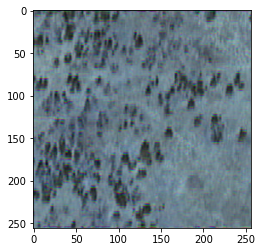

(array([[1, 1],
        [0, 0]]),
 array([[5, 4],
        [6, 7]]),
 array([[2, 5],
        [7, 1]]))

In [204]:
mask.shape
image.shape
image[0].shape
#showImg(image[0])
showImg(tf.image.flip_up_down(image[0]))
a = np.array([[[1,5,2],[1,4,5]], [[0,6,7],[0,7,1]]])
a_reshaped = np.reshape(a, (3, 2, 2))
r, g, b    = a[:, :, 0], a[:, :, 1], a[:, :, 2] 
#b = np.concatenate((r,g,b))
a.shape, a, a_reshaped.shape, a_reshaped
r,g,b
#tf.image.flip_up_down(np.array([[[1,5],[1,4]], [[0,6],[0,7]]]))

In [210]:
rgb = np.column_stack((r,g,b))
rgb.shape, rgb

((2, 6),
 array([[1, 1, 5, 4, 2, 5],
        [0, 0, 6, 7, 7, 1]]))

In [211]:
r

array([[1, 1],
       [0, 0]])

In [216]:
rgb = np.append(r, g, 0)
rgb = np.append(rgb, b, 0)
rgb.shape, rgb

((6, 2),
 array([[1, 1],
        [0, 0],
        [5, 4],
        [6, 7],
        [2, 5],
        [7, 1]]))

In [222]:
image[0].shape

TensorShape([256, 256, 3])

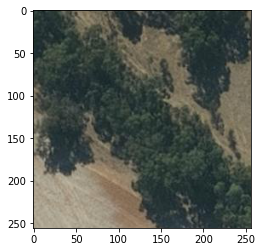

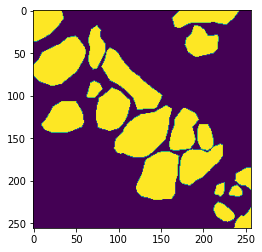

flip horizontally


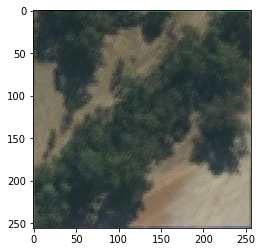

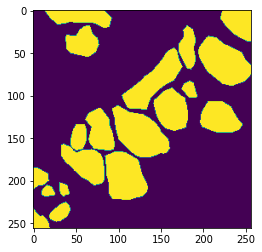

flip vertically


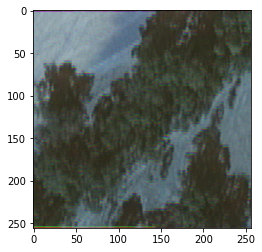

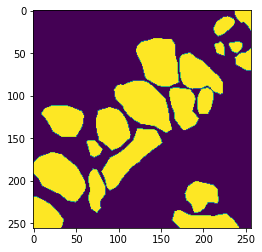

In [70]:
import tensorflow as tf
# visualize every possible flip to identify what the augmentation does and if it works

showImg(image)
showImg(mask, False)

print("flip horizontally")
hor_img = tf.image.flip_left_right(image)
hor_msk = tf.image.flip_left_right(mask)
showImg(hor_img)
showImg(hor_msk, False)
# ❗ shape has to be like this: [height, width, channels], else the augmentation does not work
print("flip vertically")
ver_img = tf.image.flip_up_down(image)
ver_msk = tf.image.flip_up_down(mask)
showImg(ver_img)
showImg(ver_msk, False)

In [140]:
hor_img.shape, hor_msk.shape, ver_img.shape, ver_msk.shape

(TensorShape([256, 256, 3]),
 TensorShape([256, 256, 1]),
 TensorShape([256, 256, 3]),
 TensorShape([256, 256, 1]))

In [ ]:
# for ndarray
import tensorflow as tf
# visualize every possible flip to identify what the augmentation does and if it works

showImg(image)
showImg(mask, False)

showImg(tf.image.flip_left_right(image))
showImg(tf.image.flip_left_right(tf.expand_dims(mask, 2)), False)
# ❗ shape has to be like this: [height, width, channels], else the augmentation does not work

flip_vertical_img = tf.image.flip_up_down(image)
flip_vertical_msk = tf.image.flip_up_down(tf.expand_dims(mask, 2))
showImg(flip_vertical_img)
showImg(flip_vertical_msk, False)

In [141]:
# flipped = tf.image.flip_left_right(image)
# visualize(image, flipped)

In [33]:
print(x_data.shape, y_data.shape)

NameError: name 'x_data' is not defined

# Inspect Dataset

In [251]:
data_flow = datagen.flow(X_train, y_train, batch_size=config.BATCH_SIZE)

In [143]:
# patch_num = 22
# print(f'??: {len(data_flow)} > X & y: {len(data_flow[0])} > All Patches: X: {data_flow[0][0].shape}, y: {data_flow[0][1].shape} > Single Patch: X: {data_flow[0][0][patch_num].shape}, y: {data_flow[0][1][patch_num].shape}')

??: 26 > X & y: 2 > All Patches: X: (32, 256, 256, 3), y: (32, 256, 256) > Single Patch: X: (256, 256, 3), y: (256, 256)


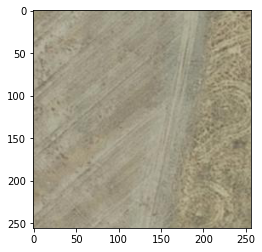

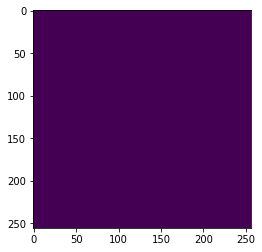

<AxesSubplot:>

In [150]:
# x = 24
# patch_num = 15
# img = np.reshape(data_flow[x][0][patch_num], (3, 256, 256))
# mask = np.reshape(data_flow[x][1][patch_num], (1, 256, 256))
# show(img)
# show(mask)

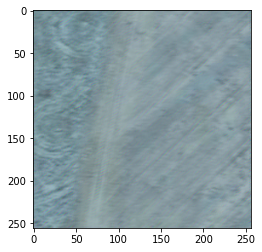

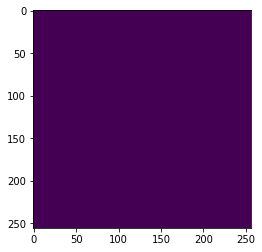

<AxesSubplot:>

In [147]:
# reshaped_patch_X = np.reshape(data_flow[x][0][patch_num], (3, 256, 256))
# reshaped_patch_y = np.reshape(data_flow[x][1][patch_num], (1, 256, 256))

# show(reshaped_patch_X)
# show(reshaped_patch_y)

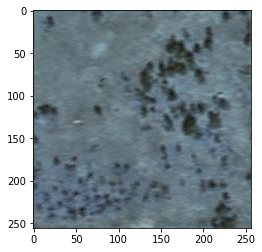

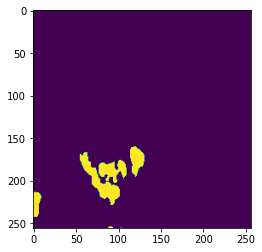

In [64]:
# showImg(data_flow[x][0][patch_num], True)
# showImg(data_flow[x][1][patch_num], False)

In [ ]:
# # 10 - 24
# x = 24
# for patch_num in range(len(data_flow[x][0])):
#     print(patch_num)
#     reshaped_patch_X = np.reshape(data_flow[x][0][patch_num],
#         (3, 256, 256))
#     reshaped_patch_y = np.reshape(data_flow[x][1][patch_num],
#         (1, 256, 256))

#     show(reshaped_patch_X)
#     show(reshaped_patch_y)

In [111]:
# for x in [100]:
#     showImg(X_train[x], True)
#     showImg(y_train[x], False)

# for x in [2, 58, 65, 67]:
#     showImg(X_train_mini[x], True)
#     showImg(y_train_mini[x], False)

In [ ]:
# for x in range(config.BATCH_SIZE):
#     showImg(data_flow[0][0][x], True)
#     showImg(data_flow[0][1][x], False)